# Assignment 8: Approximation of the Probability Distributions

---
## Background

### Problem Analysis
Data samples from real-world problems are often assumed to be drawn from the Gaussian distribution
due to convenience (many statistical tests assume normality) or known Gaussian properties of the
problem at hand. If a normality test is performed a priori to a particular statistical test and the result is
negative, the corresponding non-parametric statistical test can be used instead. However, in some cases
we would like to know more about the likely distribution of data than whether it is Gaussian or not. We
are interested in determining the likely distribution of the data sample.
1. Analyse the data samples in Table 9 and find a suitable method for approximating the probability
distributions of the samples. Motivate the choice of method, identify the likely distributions, and
discuss the validity of the selected method.

### The Methods
#### Kolmogorov-Smirnov Test
The kolmogorov-smirnov test is a non-parametric test to compare the cumulative distribution function of a sample with the CDF of another sample or idealize distribution (further referred to as expected).
For that purpose, it calculates the greatest distance between the two CDF's.

The hypotheses tested are:
- $H_0:$ The sample in question comes from the expected distribution
- $H:$ The sample does not come from the expected distribution

Hence if the kolmogorov-smirnov test yields a p value $<0.05$, the sample is not from the expected distribution.

**Assumptions**
- Requires continuous data
- Data must be independent and identically distributed
- Sample size needs to be big for accurate results

#### Chi-Square Goodness-of-Fit Test
The Chi-Square Goodness-of-Fit Test assesses whether the observed frequency distribution of a sample matches a specified theoretical distribution. It compares observed (O_i) and expected (E_i) frequencies using the test statistic:
$$X^2 = \sum \frac{(O_i - E_i)^2}{E_i}$$

The hypotheses tested are:
- $H_0:$ The sample in question comes from the expected distribution
- $H:$ The sample does not come from the expected distribution

Hence if the chi-square goodness-of-fit test yields a p value $<0.05$, the sample is not from the expected distribution.

**Assumptions**
- Requires categorical data (but continuous data can be grouped into bins)
- Data must be independent and identically distributed

#### Akaike Information Criterion
The Akaike Information Criterion (AIC) is a method for model selection. It quantifies the trade-off between the goodness of fit of a statistical model and the model’s complexity. AIC is calculated as:
$$AIC = 2k - 2ln(L)$$
with:
- $k:$ Number of paramters in the model
- $ln(L)$: Log-likehood of model

The lower the AIC value, the better the traceoff between a good fit to the data and simplicity of the model.

**Assumptions**
- The dataset used for comparison must be the same across all models
- Data must be independent and identically distributed
- The sample size should be large enough for reliable maximum likelihood estimation


---
## Solution

In [158]:
import pandas as pd
import scipy.stats as stats
import numpy as np


df_9 = pd.read_csv('data/table_9.csv', delimiter=";")
df_9.head()

,Observation,Measure1,Measure2,Measure3,Measure4
0,1,1,"2,811","-1,385","54,151"
1,2,2,"10,357","0,038","70,440"
2,3,3,"4,970","-0,763","75,764"
3,4,2,"12,147","0,212","69,844"
4,5,2,"36,921","1,426","61,136"


In [159]:
df_9.shape

(1000, 5)

In [160]:
# convert values
df_9['Measure1'] = df_9['Measure1'].astype(int)
df_9['Measure2'] = df_9['Measure2'].apply(lambda x: x.replace(',', '.')).astype(float)
df_9['Measure3'] = df_9['Measure3'].apply(lambda x: x.replace(',', '.')).astype(float)
df_9['Measure4'] = df_9['Measure4'].apply(lambda x: x.replace(',', '.')).astype(float)

### 8.1

To analyse the distributions we'll first start with a histogram plot of the variables.  
Afterward we'll use the Kolmogorov-Smirnov test to understand how well the variable's distribution fits the assumed distribution

array([[<Axes: title={'center': 'Measure4'}>]], dtype=object)

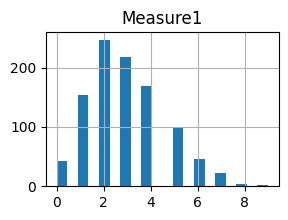

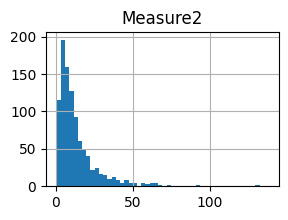

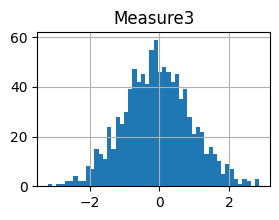

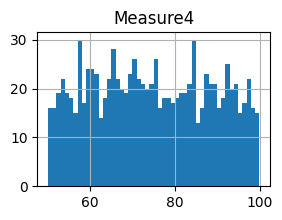

In [161]:
# histogram plot for each variable
df_9.hist(column=['Measure1'], bins=20, figsize=(3, 2))
df_9.hist(column=['Measure2'], bins=50, figsize=(3, 2))
df_9.hist(column=['Measure3'], bins=50, figsize=(3, 2))
df_9.hist(column=['Measure4'], bins=50, figsize=(3, 2))

Visual analysis of the variables yields the following conclusions:

### Measure 1
- The variable peaks around 2-4: So most data is concentrated in this range.
- The variable has a right-skew: The tail extends more to the right (higher values) than the left, so the variable is not symmetric.
- Hence the variable follows either a gamma distribution or a log-normal distribution. 
- For the statistical validation we will use the Chi-Square Goodness-of-Fit Test since the variable consists of discrete values violating the continuous assumption of the kolmogorov-smirnov test.

### Measure 2
- The variable is highly right-skewed: Most data values are concentrated close to 0, with a long tail extending to the right.
- Non-negative values: The data is strictly non-negative, with a close to 0.
- Hence the variable follows either an exponential distribution, a gamma distribution or a log-normal distribution.
- For the statistical validation we will use the kolmogorov-smirnov test.

### Measure 3
- The variable has a single peak: Indicating that the data is concentrated in this range.
- Symmetrical Shape: The data is symmetrically distributed around the mean (approx 0).
- Smooth Tails: The frequency decreases smoothly as values move away from the center in both directions similarly.
- Hence the variable follows a normal distribution.
- For the statistical validation we will use the kolmogorov-smirnov test.

### Measure 4
- Uniform Shape: The heights of the bars are somewhat consistent across the range of values, with no central peak or skew.
- Range: The data seems evenly distributed across the interval (60-100).
- Hence the variable follows a uniform distribution.
- For the statistical validation we will use the kolmogorov-smirnov test.

## Measure 1

In [162]:
def validate_distribution_for_measure_chi_squared(distribution, variable):
    # fit the gamma distribution based on Measure 1
    alpha, *bla = distribution.fit(variable)

    # calculate the expected frequencies
    observed_values, bin_edges = np.histogram(variable, bins=10)
    cumulative_prob = distribution.cdf(bin_edges, alpha, *bla)
    expected_values = np.diff(cumulative_prob) * df_9.shape[0]
    expected_values *= observed_values.sum() / expected_values.sum()

    # calculate the chi-square statistic
    chi_square_stat, p_value = stats.chisquare(observed_values, expected_values)
    if p_value < 0.05:
        return False, chi_square_stat, p_value
    else:
        return True, chi_square_stat, p_value

Initially, I ran this code only for the gamma and the lognorm distribution. However, since none of them seemed appropriate, I extended it to the following other distributions:
- normal distribution
- exponentially modified normal
- exponentially modified weibull
- weibull minimum/maximum

In [163]:
for stat in [stats.gamma, stats.lognorm, stats.norm, stats.exponnorm, stats.uniform]:
    accept, stat_res, p = validate_distribution_for_measure_chi_squared(stat, df_9['Measure1'])
    if accept:
        print('The null hypothesis (Measure 1 can be approximated with a {} distribution) is accepted: p-value:{}, difference: {}'.format(stat, p, stat_res))
    else:
        print('The null hypothesis (Measure 1 can be approximated with a {} distribution) is rejected: p-value:{}, difference: {}'.format(stat, p, stat_res))

The null hypothesis (Measure 1 can be approximated with a <scipy.stats._continuous_distns.gamma_gen object at 0x1432b5810> distribution) is rejected: p-value:0.00012622780489905403, difference: 33.140631324708345
The null hypothesis (Measure 1 can be approximated with a <scipy.stats._continuous_distns.lognorm_gen object at 0x1432dcd90> distribution) is rejected: p-value:0.0, difference: 121736.40609900793
The null hypothesis (Measure 1 can be approximated with a <scipy.stats._continuous_distns.norm_gen object at 0x143281210> distribution) is rejected: p-value:0.0006993362877563109, difference: 28.803676057856098
The null hypothesis (Measure 1 can be approximated with a <scipy.stats._continuous_distns.exponnorm_gen object at 0x1373b5590> distribution) is rejected: p-value:0.003210327761864278, difference: 24.791802012796037
The null hypothesis (Measure 1 can be approximated with a <scipy.stats._continuous_distns.uniform_gen object at 0x144cc77d0> distribution) is rejected: p-value:2.967

/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6120: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Since the distribution does not fit any of those distributions, we'll now the akaike information criterion to analyze which of the model will fit Measurement 1 the best (even though I) know, that none of them will fit well). I could also go for the bayesian information criterion, but it penalizes heavier than the akaike information criterion.

In [164]:
results = []
for distribution in [stats.gamma, stats.lognorm, stats.norm, stats.exponnorm, stats.uniform]:
    try:
        # Fit the distribution to the data
        params = distribution.fit(df_9['Measure1'])
        # Calculate log-likelihood
        log_likelihood = np.sum(distribution.logpdf(df_9['Measure1'], *params))
        # Number of parameters in the distribution
        k = len(params)
        # Compute AIC
        aic = 2 * k - 2 * log_likelihood
        # Append results
        results.append({"Distribution": distribution, "AIC": aic})
    except Exception as e:
        print(f"Could not fit {distribution}: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find the best-fitting distribution
best_fit = results_df.loc[results_df['AIC'].idxmin()]

# Display the results
print("AIC Results:")
print(results_df)
print("\nBest-Fitting Distribution:")
print(best_fit)

AIC Results:
                                        Distribution           AIC
0  <scipy.stats._continuous_distns.gamma_gen obje...   3779.979411
1  <scipy.stats._continuous_distns.lognorm_gen ob... -47799.219676
2  <scipy.stats._continuous_distns.norm_gen objec...   3839.206072
3  <scipy.stats._continuous_distns.exponnorm_gen ...   3804.230540
4  <scipy.stats._continuous_distns.uniform_gen ob...   4398.449155

Best-Fitting Distribution:
Distribution    <scipy.stats._continuous_distns.lognorm_gen ob...
AIC                                                 -47799.219676
Name: 1, dtype: object


### Interpretation
- From the AIC values its seems lognorm would be the best fitting distribution, however the chi-square goodness-of-fit difference values indicate differently.
- Since I couldn't figure out why the values for lognorm are negative (and hence seem to be the best) I'll go with the second best model, which would be the Gamma distribution

## Measure 2

In [165]:
def validate_distribution_for_measure_kolmogorov_smirnov(distribution, variable):
    # fit the gamma distribution based on Measure 1
    alpha, *bla = distribution.fit(variable)

    # calculate the expected frequencies
    observed_values, bin_edges = np.histogram(variable, bins=10)
    cumulative_prob = distribution.cdf(bin_edges, alpha, *bla)
    expected_values = np.diff(cumulative_prob) * df_9.shape[0]
    expected_values *= observed_values.sum() / expected_values.sum()

    # calculate the kolmorogov-smirnov statistic
    ks_stat, p_value = stats.kstest(variable, distribution.cdf, args=(alpha, *bla))
    if p_value < 0.05:
        return False, ks_stat, p_value
    else:
        return True, ks_stat, p_value

In [166]:
for distr in [stats.expon, stats.gamma, stats.lognorm]:
    accept, diff, p = validate_distribution_for_measure_kolmogorov_smirnov(distr, df_9['Measure2'])
    if accept:
        print('The null hypothesis (Measure 2 can be approximated with a {} distribution) is accepted: p-value:{}, difference: {}'.format(distr, p, diff))
    else:
        print('The null hypothesis (Measure 2 can be approximated with a {} distribution) is rejected: p-value:{}, difference: {}'.format(distr, p, diff))

The null hypothesis (Measure 2 can be approximated with a <scipy.stats._continuous_distns.expon_gen object at 0x143293510> distribution) is rejected: p-value:9.98405060799339e-05, difference: 0.07017698426642133
The null hypothesis (Measure 2 can be approximated with a <scipy.stats._continuous_distns.gamma_gen object at 0x1432b5810> distribution) is rejected: p-value:0.0002052722640542186, difference: 0.06757202947575847
The null hypothesis (Measure 2 can be approximated with a <scipy.stats._continuous_distns.lognorm_gen object at 0x1432dcd90> distribution) is accepted: p-value:0.997708303783065, difference: 0.012313530667442868


### Interpretation
- The variable can be described with a Log-Norm distribution

## Measure 3

In [167]:
for distr in [stats.norm]:
    accept, diff, p = validate_distribution_for_measure_kolmogorov_smirnov(distr, df_9['Measure3'])
    if accept:
        print('The null hypothesis (Measure 3 can be approximated with a {} distribution) is accepted: p-value:{}, difference: {}'.format(distr, p, diff))
    else:
        print('The null hypothesis (Measure 3 can be approximated with a {} distribution) is rejected: p-value:{}, difference: {}'.format(distr, p, diff))

The null hypothesis (Measure 3 can be approximated with a <scipy.stats._continuous_distns.norm_gen object at 0x143281210> distribution) is accepted: p-value:0.9895847648687272, difference: 0.013833425273020894


### Interpretation
- The variable can be described with a normal distribution

## Measure 4

In [168]:
for distr in [stats.uniform]:
    accept, diff, p = validate_distribution_for_measure_kolmogorov_smirnov(distr, df_9['Measure4'])
    if accept:
        print('The null hypothesis (Measure 4 can be approximated with a {} distribution) is accepted: p-value:{}, difference: {}'.format(distr, p, diff))
    else:
        print('The null hypothesis (Measure 4 can be approximated with a {} distribution) is rejected: p-value:{}, difference: {}'.format(distr, p, diff))

The null hypothesis (Measure 4 can be approximated with a <scipy.stats._continuous_distns.uniform_gen object at 0x144cc77d0> distribution) is accepted: p-value:0.5107726146704352, difference: 0.025789727963434483


### Interpretation
- The variable can be described with a uniform distribution